In [40]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import scipy
import librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from skimage.transform import resize
import sklearn as skl
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from keras.layers import Dense, Dropout, Flatten, Normalization
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Helper functions

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print(f"Saved model to {filename_base}.json and weights to {filename_base}.h5")


def show_data_raw(x, y_num, y_gender):
    gender_ = 0
    fig1, axs1 = plt.subplots(3, 3, figsize=(10, 10))
    # iterating through the digits 0-9
    for i, ax in zip(range(0, 10), axs1.ravel()):
        # we want to show some variety in the genders, so we are alternating genders
        # and seeking the next sample with correct gender/digit
        gender_ = 1 - gender_
        if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
            continue
        index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]

        # extracting the waveform and the labels
        audio_track = x[index_to_show]
        num_speak = y_num[index_to_show]
        gender_spoke = y_gender[index_to_show]
        gender_spoke = 'male' if gender_spoke == 0 else 'female'

        # plotting
        ax.plot(
            list(range(1, 8000 + 1, 1)),
            audio_track,
        )
        ax.set_ylabel('Amplitude')
        ax.set_xlabel('Samples')
        ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} person')

    fig1.suptitle(
        'Raw waveforms of selected audio tracks',
        fontsize=12,
        weight='bold',
    )
    fig1.tight_layout(pad=1)
    plt.show()

def show_data_fft(x, y_num, y_gender):
    gender_ = 0
    fig2, axs2 = plt.subplots(3, 3, figsize=(10, 10))
    # iterating through the digits 0-9
    for i, ax in zip(range(0, 10), axs2.ravel()):
        # we want to show different genders in this preview, so alternating genders
        gender_ = 1 - gender_
        # find the next sample with correct gender and digit
        if len(np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])) == 0:
            continue
        index_to_show = np.intersect1d(np.where(y_num == i)[0], np.where(y_gender == gender_)[0])[0]
        audio_track = x[index_to_show]
        num_speak = y_num[index_to_show]
        gender_spoke = y_gender[index_to_show]
        gender_spoke = 'male' if gender_spoke == 0 else 'female'
        # the spectrogram is computed through the use of the Short Time Fourier Transform (STFT)
        # see https://en.wikipedia.org/wiki/Short-time_Fourier_transform
        f, t, Zxx = scipy.signal.stft(audio_track, 8000, nperseg=455, noverlap=393, window='hann')
        Zxx_ = np.abs(Zxx[0:227, 2:-1])
        Zxx_ = np.atleast_3d(Zxx_).transpose(2,0,1)
        # after the STFT, the spectrogram is simply computed by taking the amplitude of the Fourier coefficients.
        Zxx_ = librosa.amplitude_to_db(Zxx_, ref=np.max)

        #
        f_, t_ = f[:227], t[:227]

        # to be able to fit everything in memory, we'll resize the spectrogram to images of size 128x128
        # this is not strictly necessary here, but when you try to load the entire dataset in memory, that will be
        # useful.
        f_ = resize(f_, (128, ))
        t_ = resize(t_, (128, ))
        Zxx_ = resize(Zxx_, (1, 128, 128))

        ax.set_title(f'Number {num_speak} spoken by a {gender_spoke} candidate ', fontsize=10)
        ax.pcolormesh(t_, f_, Zxx_[0, :, :], shading='gouraud')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')

    fig2.suptitle(
        'Short Time Fourier Transformed (STFT) spectrograms of selected audio tracks',
        fontsize=12,
        weight='bold',
    )
    fig2.tight_layout(pad=1)
    plt.show()

In [50]:
x_d = np.load('xtrain.npy')
y_num = np.load('ytrain_num.npy')
y_gender = np.load('ytrain_gender.npy')

def prepare_data(X,Y):
    X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train = one_hot_encoder.fit_transform(Y_train.reshape(-1, 1)) 
    Y_validation = one_hot_encoder.fit_transform(Y_validation.reshape(-1, 1)) 
    return X_train, X_validation, Y_train, Y_validation

X_train, X_validation, Y_train, Y_validation = prepare_data(x_d, y_num)


In [55]:
inputs = keras.layers.Input(shape=(8000, 1))
x = inputs
x = Normalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)


predictions = Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model.summary()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 8000, 1)]         0         
                                                                 
 normalization_6 (Normaliza  (None, 8000, 1)           3         
 tion)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 8000)              0         
                                                                 
 dense_90 (Dense)            (None, 1024)              8193024   
                                                                 
 dropout_30 (Dropout)        (None, 1024)              0         
                                                                 
 dense_91 (Dense)            (None, 512)               524800    
                                                          

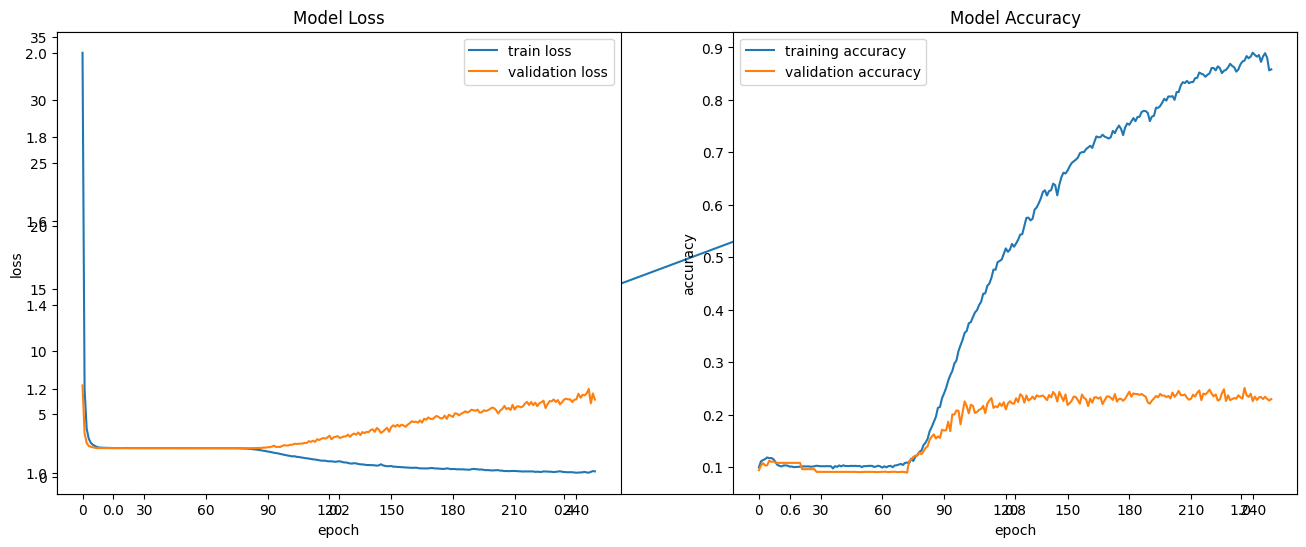

22/22 [==============================] - 18s 812ms/step - loss: 0.4503 - accuracy: 0.8583 - val_loss: 6.1620 - val_accuracy: 0.2296
Epoch 251/300
11/22 [==============>...............] - ETA: 8s - loss: 0.4203 - accuracy: 0.8644

KeyboardInterrupt: 

In [56]:
num_epochs = 300
pltCallBack = PlotLossAccuracy()
model.fit(X_train, Y_train,
        batch_size=1024, epochs=num_epochs,
        validation_data=(X_validation, Y_validation),
        callbacks=[pltCallBack])
